## Load Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader
from torchsummary import summary
from torch.optim import lr_scheduler
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import os
from PIL import Image
from torch.nn.functional import log_softmax
import torchvision.models as models

torch.cuda.empty_cache()
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = True

## Utility/Functions

In [7]:
class FCN_Resnet18(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        model_res18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

        # Encoder (ResNet18)
        self.layer0 = nn.Sequential( 
            model_res18.conv1,
            model_res18.bn1,
            model_res18.relu,
            model_res18.maxpool
        )
        self.layer1 = model_res18.layer1 
        self.layer2 = model_res18.layer2 
        self.layer3 = model_res18.layer3  
        self.layer4 = model_res18.layer4  

        # Decoder (with skip connections)
        self.deconv1 = nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1)  # x32 -> x16
        self.bn1 = nn.BatchNorm2d(256)

        self.deconv2 = nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1)  # x16 -> x8
        self.bn2 = nn.BatchNorm2d(128)

        self.deconv3 = nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1)   # x8 -> x4
        self.bn3 = nn.BatchNorm2d(64)

        self.deconv4 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)     # x4 -> x2
        self.bn4 = nn.BatchNorm2d(64)

        self.deconv5 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1)     # x2 -> x1
        self.bn5 = nn.BatchNorm2d(32)

        self.classifier = nn.Conv2d(32, num_classes, kernel_size=1)

        self.relu = nn.ReLU(inplace=True)
        self.drop = nn.Dropout2d(p=0.15)


    def forward(self, x):
        x0 = self.layer0(x)  
        x1 = self.layer1(x0)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)

        x = self.relu(self.bn1(self.deconv1(x4))) 
        x = self.drop(x + x3)

        x = self.relu(self.bn2(self.deconv2(x)))  
        x = self.drop(x + x2)

        x = self.relu(self.bn3(self.deconv3(x)))   
        x = self.drop(x + x1)

        x = self.drop(self.relu(self.bn4(self.deconv4(x)))) 
        x = self.drop(self.relu(self.bn5(self.deconv5(x))))

        out = self.classifier(x)

        return out


def validate_seg_model(epoch, model, val_loader, n_class, iu_scores, pixel_scores):
    model.eval()
    total_pixels = 0
    correct_pixels = 0
    iou_per_class = np.zeros(n_class)
    iou_counts = np.zeros(n_class)

    with torch.no_grad():
        for batch in val_loader:
            images = batch[0].cuda()
            true_masks = batch[1].cuda()

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            for cls in range(n_class):
                pred_inds = (preds == cls)
                target_inds = (true_masks == cls)

                intersection = (pred_inds & target_inds).sum().item()
                union = (pred_inds | target_inds).sum().item()

                if union > 0:
                    iou_per_class[cls] += intersection / union
                    iou_counts[cls] += 1

            correct_pixels += (preds == true_masks).sum().item()
            total_pixels += torch.numel(true_masks)

    mean_iou = (iou_per_class / np.maximum(iou_counts, 1)).mean()
    pixel_accuracy = correct_pixels / total_pixels

    iu_scores[epoch, :] = iou_per_class / np.maximum(iou_counts, 1)
    pixel_scores[epoch] = pixel_accuracy

    print(f"[Validation Epoch {epoch}] Pixel Accuracy: {pixel_accuracy:.4f} | Mean IoU: {mean_iou:.4f}")



def seg_train(model,epochs,train_loader,val_loader,optimizer,criterion,n_class):
    model.train()
    loss_track=[]
    iu_scores    = np.zeros((epochs, n_class))
    pixel_scores = np.zeros(epochs)

    for epoch in range(epochs):
        loss_train=0.0
        for iter, batch in enumerate(train_loader):
            optimizer.zero_grad()

            inputs = batch[0].cuda()
            labels = batch[1].cuda()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
        
        loss_track.append(loss_train/iter)
        if epoch ==0 or epoch % 2 == 0:
            print("epoch{}, loss: {}".format(epoch, loss_train/iter))

        validate_seg_model(epoch, model, val_loader, n_class, iu_scores, pixel_scores)
        
    return loss_track,iu_scores,pixel_scores


class voc_data_load(torch.utils.data.Dataset):
    def __init__(self,rootpath,folder_data,folder_mask,filelist,n_class,colormap,download=0):
        
        if download==1:
            input_transforms = transforms.Compose([
                transforms.Resize((256, 256)),
                transforms.ToTensor(),
            ])
            train_dataset = torchvision.datasets.VOCSegmentation(
                root=rootpath,
                year='2012',
                image_set='train',
                download=True,
                transform=input_transforms
            )

        self.img_folder = folder_data
        self.seg_folder = folder_mask
        self.img_list = os.listdir(folder_data)
        self.seg_list = os.listdir(folder_mask)
        self.transform = transforms.Compose([
                            transforms.Resize((256, 256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
        
        self.mask_transforms = transforms.Compose([
                                transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST),
                                transforms.ToTensor()])
        
        self.filelist = filelist
        self.n_class = n_class
        self.colormap = colormap
    
    def __len__(self):
        return len(self.filelist)
    
    def __getitem__(self,idx):
        img = Image.open(self.img_folder + "/" + self.filelist[idx] + ".jpg").convert('RGB')
        img = self.transform(img)
        
        seg = Image.open(self.seg_folder + "/" + self.filelist[idx] + ".png").convert("RGB")
        seg = seg.resize((256, 256), Image.NEAREST)
        seg = np.array(seg)
        segmentation_mask = np.zeros((256, 256, len(self.colormap)), dtype=np.float32)
        for label_index, label in enumerate(self.colormap):
            segmentation_mask[:, :, label_index] = np.all(seg == label, axis=-1).astype(float)
        segmentation_mask = np.transpose(segmentation_mask,(2,0,1))
        segmentation_mask = torch.from_numpy(segmentation_mask)
        segmentation_mask = segmentation_mask.argmax(dim=0).squeeze().long()

        return img, segmentation_mask
    
def get_class_weights(target, n_classes):
    class_sample_count = np.bincount(target, minlength=n_classes)
    weight = 1. / np.log(class_sample_count + 1e-6)  # Avoid division by zero
    #weight = weight / weight.sum()  # Normalize if needed
    return torch.tensor(weight, dtype=torch.float32)

label_name = ["background", "aeroplane", "bicycle", "bird", "boat",
              "bottle", "bus", "car", "cat", "chair", "cow", "dining table",
              "dog", "horse", "motorbike", "person", "potted plant",
              "sheep", "sofa", "train", "tv/monitor"]

label_color = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
               [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
               [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
               [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
               [0, 192, 0], [128, 192, 0], [0, 64, 128]
               ]    

## Load Data

In [4]:
##Load Training Data
n_class=21
rootpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data"
trainpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/ImageSets/Segmentation/train.txt"
readfunc = open(trainpath, "r").read().split('\n')
readfunc = readfunc[:1464]
original_images = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/JPEGImages"
segmentation_mask = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/SegmentationClass"
traindataset = voc_data_load(rootpath,original_images,segmentation_mask,readfunc,n_class,label_color)
train_loader = DataLoader(traindataset, batch_size=8, shuffle=True, num_workers=16)


##Load Validation Data
valpath = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt"
readfunc = open(valpath, "r").read().split('\n')
readfunc = readfunc[:1449]
valdataset = voc_data_load(rootpath,original_images,segmentation_mask,readfunc,n_class,label_color)
val_loader = DataLoader(valdataset, batch_size=4, num_workers=16)

In [8]:
## Calculating for Class Weight
all_labels = []

for _, mask in train_loader:
    labels_np = mask.numpy().flatten()
    all_labels.extend(labels_np)

all_labels = np.array(all_labels)
class_weights = get_class_weights(all_labels, n_classes=21)

class_weights.shape,np.unique(all_labels), class_weights

(torch.Size([21]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 tensor([0.0553, 0.0745, 0.0800, 0.0736, 0.0755, 0.0756, 0.0699, 0.0710, 0.0680,
         0.0721, 0.0738, 0.0715, 0.0702, 0.0732, 0.0722, 0.0654, 0.0752, 0.0735,
         0.0709, 0.0705, 0.0734]))

## Train Model

In [19]:
## If Model is trained then load trained model and evaluate results. Else start a new training
model_path = "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/models/res18_fcn_clsweight_v0.pth999"

if os.path.exists(model_path):
    fcn_model = FCN_Resnet18(num_classes=n_class).cuda()
    fcn_model.load_state_dict(model_path)
else:
    lr = 1e-4
    epochs = 30
    n_class = 21
    momentum = 0.99
    w_decay = 1e-4

    fcn_model = FCN_Resnet18(num_classes=n_class).cuda()
    criterion = nn.CrossEntropyLoss(weight=class_weights.cuda(), ignore_index=255)
    optimizer = torch.optim.AdamW(fcn_model.parameters(), lr=lr)

    loss_track,iu_scores,pixel_scores = seg_train(fcn_model,epochs,train_loader,val_loader,optimizer,criterion,n_class)
    torch.save(fcn_model.state_dict(), "/home/urseismoadmin/Documents/PRJ_DL_PRACTICE/ECE_484_Coursework/HW5/models/res18_fcn_clsweight_v0.pth")

epoch0, loss: 2.6702581709557838
[Validation Epoch 0] Pixel Accuracy: 0.7452 | Mean IoU: 0.0493
[Validation Epoch 1] Pixel Accuracy: 0.7715 | Mean IoU: 0.0524
epoch2, loss: 1.0216870628870451
[Validation Epoch 2] Pixel Accuracy: 0.7836 | Mean IoU: 0.0674
[Validation Epoch 3] Pixel Accuracy: 0.7807 | Mean IoU: 0.0617
epoch4, loss: 0.8196014116753588
[Validation Epoch 4] Pixel Accuracy: 0.7933 | Mean IoU: 0.0804
[Validation Epoch 5] Pixel Accuracy: 0.7955 | Mean IoU: 0.0841
epoch6, loss: 0.668993524142674
[Validation Epoch 6] Pixel Accuracy: 0.7932 | Mean IoU: 0.0838
[Validation Epoch 7] Pixel Accuracy: 0.8107 | Mean IoU: 0.0960
epoch8, loss: 0.5570623267974172
[Validation Epoch 8] Pixel Accuracy: 0.8087 | Mean IoU: 0.0968
[Validation Epoch 9] Pixel Accuracy: 0.8202 | Mean IoU: 0.1131
epoch10, loss: 0.45627055096102287
[Validation Epoch 10] Pixel Accuracy: 0.8070 | Mean IoU: 0.1175
[Validation Epoch 11] Pixel Accuracy: 0.8092 | Mean IoU: 0.1266
epoch12, loss: 0.4473443437408615
[Validati

## Validate Model and Visualize Results on Train Dataset

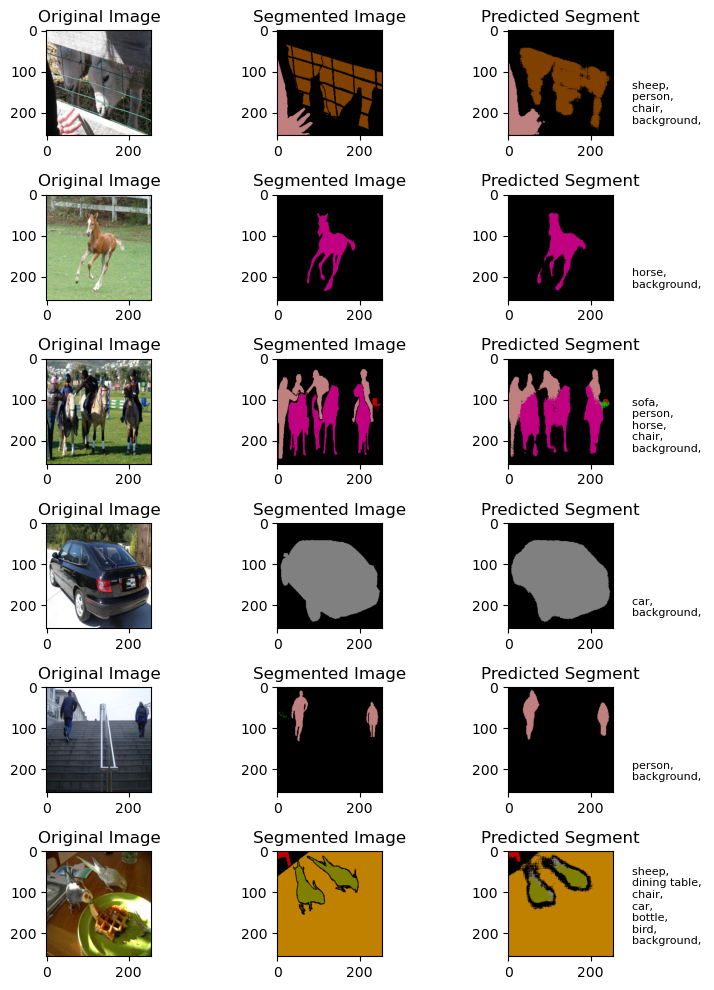

In [20]:
fcn_model.eval()
img, seg = next(iter(train_loader))

with torch.no_grad():
    out = fcn_model(img.cuda())
    plt_cnt=1
    plt.figure(figsize=(8,10))
    labelnames = []

    for idx in range(0,6):
        #print(out.shape)
        y_predict = out[idx].cpu().numpy()
        #print(y_predict.shape)
        y_predict = out[idx].argmax(dim=0).cpu().numpy()
        #print(y_predict.shape)

        labels_temp = ''
        for i in np.unique(y_predict).tolist():
            #print('Predcited label',label_name[i])
            labels_temp = label_name[i] + ', \n' + labels_temp

            color_mask = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask[seg[idx]==i] = np.array(color)
            
            color_mask_predict = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask_predict[y_predict==i] = np.array(color)
        labelnames.append(labels_temp)


        pltimg = np.transpose(img[idx],(1, 2, 0))
        mean=torch.tensor([0.485, 0.456, 0.406])
        std=torch.tensor([0.229, 0.224, 0.225])
        pltimg = std * pltimg + mean

        plt.subplot(6,3,plt_cnt)
        plt.imshow(np.clip(pltimg.numpy(),0,1))
        plt.title('Original Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask.astype(np.int32))
        plt.title('Segmented Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask_predict.astype(np.int32))
        plt.text(300,255,labelnames[idx],fontsize=8)
        plt.title('Predicted Segment')
        plt_cnt+=1

    plt.tight_layout()
    plt.show()



## Validate Model and Visualize Results on Validation Dataset

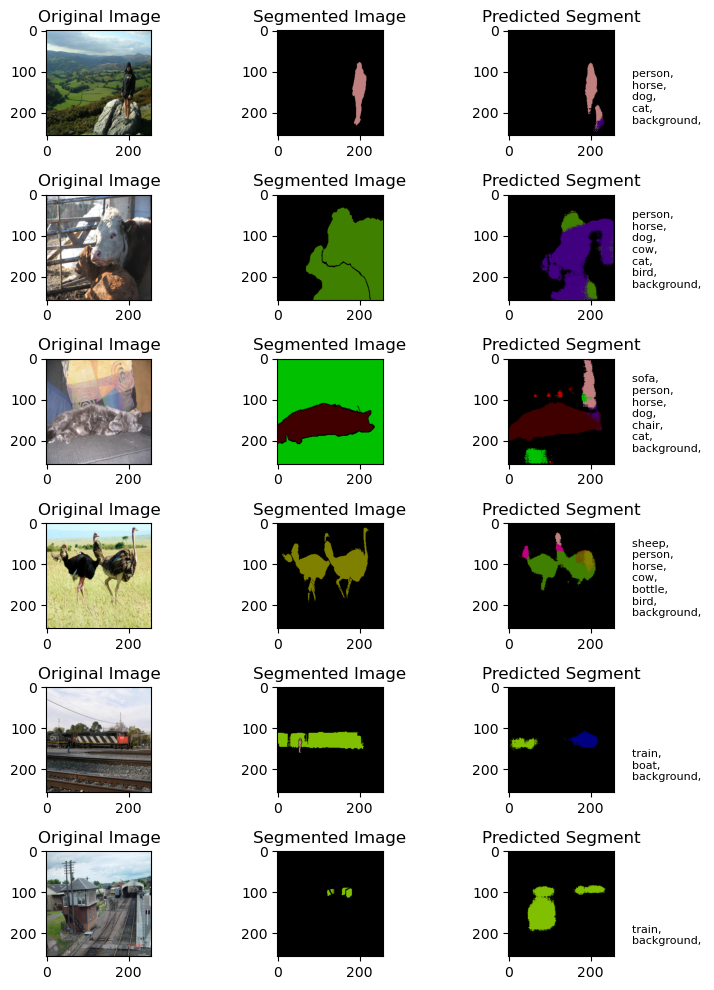

In [22]:
fcn_model.eval()
val_loader = DataLoader(valdataset, batch_size=6, num_workers=16, shuffle=True)
img, seg = next(iter(val_loader))

with torch.no_grad():
    out = fcn_model(img.cuda())
    plt_cnt=1
    plt.figure(figsize=(8,10))
    labelnames = []

    for idx in range(0,6):
        #print(out.shape)
        y_predict = out[idx].cpu().numpy()
        #print(y_predict.shape)
        y_predict = out[idx].argmax(dim=0).cpu().numpy()
        #print(y_predict.shape)

        labels_temp = ''
        for i in np.unique(y_predict).tolist():
            #print('Predcited label',label_name[i])
            labels_temp = label_name[i] + ', \n' + labels_temp

            color_mask = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask[seg[idx]==i] = np.array(color)
            
            color_mask_predict = np.zeros((*y_predict.shape, 3))
            for i, color in enumerate(label_color):
                color_mask_predict[y_predict==i] = np.array(color)
        labelnames.append(labels_temp)


        pltimg = np.transpose(img[idx],(1, 2, 0))
        mean=torch.tensor([0.485, 0.456, 0.406])
        std=torch.tensor([0.229, 0.224, 0.225])
        pltimg = std * pltimg + mean

        plt.subplot(6,3,plt_cnt)
        plt.imshow(np.clip(pltimg.numpy(),0,1))
        plt.title('Original Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask.astype(np.int32))
        plt.title('Segmented Image')
        plt_cnt+=1
        plt.subplot(6,3,plt_cnt)
        plt.imshow(color_mask_predict.astype(np.int32))
        plt.text(300,255,labelnames[idx],fontsize=8)
        plt.title('Predicted Segment')
        plt_cnt+=1


    plt.tight_layout()
    plt.show()

## Plot Loss Function and Metrics

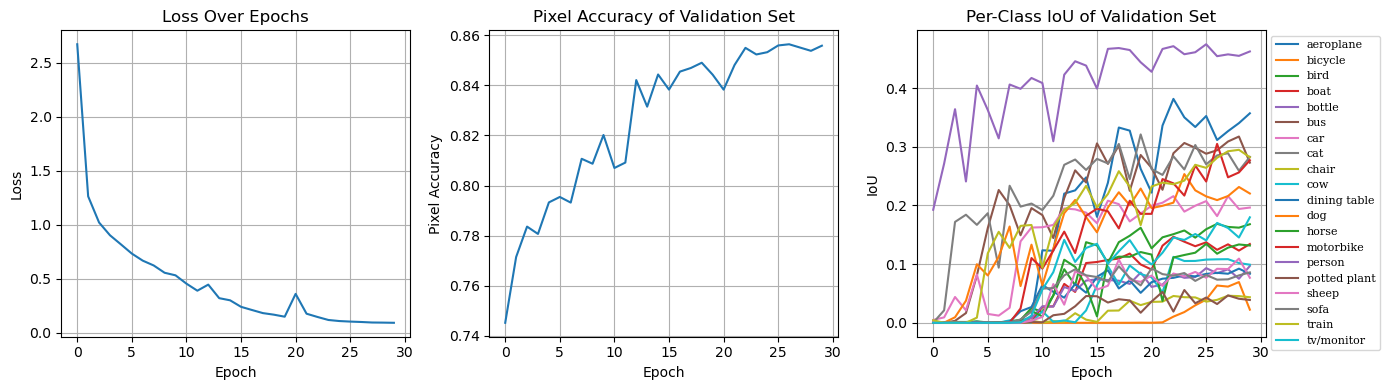

In [23]:
plt.figure(figsize=(14,4))
plt.subplot(1,3,1)
plt.plot(loss_track)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.grid(True)

plt.subplot(1,3,2)
plt.plot(pixel_scores)
plt.xlabel('Epoch')
plt.ylabel('Pixel Accuracy')
plt.title('Pixel Accuracy of Validation Set')
plt.grid(True)

plt.subplot(1,3,3)
for cls in range(n_class-1):
    plt.plot(range(epochs), iu_scores[:, cls+1], label=label_name[cls+1])

plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Per-Class IoU of Validation Set')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.legend(prop={'size': 8, 'family': 'serif'}, loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()